# Physics-Informed Neural Network for the Lorenz System

This notebook implements a PINN for solving the Lorenz system of ODEs using DeepXDE.

In [1]:
import deepxde as dde
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Data Loading

First, we define a function to load and process the training data.

In [2]:
def load_training_data(params):
    """Load and process training data"""
    training_data = np.load('../../../data/lorenz_training.npy')
    t = np.linspace(0, params['T'], training_data.shape[0])
    
    # Create observation points
    X_train = t[:, None]  # Time points
    y_train = training_data
    
    return X_train, y_train

## PINN Model Definition

Next, we define the PINN model including:
- ODE system definition
- Initial conditions
- Neural network architecture

In [3]:
def ode_system(x, y):
    """Lorenz system ODEs with learnable parameters:
    dx/dt = sigma * (y - x)
    dy/dt = x * (rho - z) - y
    dz/dt = x * y - beta * z
    """
    # Get the components of y
    x_coord, y_coord, z_coord = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    
    # Get time derivatives
    dx_t = dde.grad.jacobian(y, x, i=0)
    dy_t = dde.grad.jacobian(y, x, i=1)
    dz_t = dde.grad.jacobian(y, x, i=2)
    
    # Use learnable parameters from the model
    sigma = model.net.sigma
    rho = model.net.rho
    beta = model.net.beta
    
    # Lorenz equations
    return [
        dx_t - sigma * (y_coord - x_coord),
        dy_t - (x_coord * (rho - z_coord) - y_coord),
        dz_t - (x_coord * y_coord - beta * z_coord)
    ]

def boundary(_, on_initial):
    return on_initial

def lorenz_pinn(params=None, load_pretrained=False, model_path=None):
    if params is None:
        params = {
            'T': 100,
            'dt': 0.01,
        }
    
    # Create the domain
    geom = dde.geometry.TimeDomain(0, params['T'])
    
    # Load training data
    X_train, y_train = load_training_data(params)
    
    # Set initial conditions from first data point
    ic1 = dde.IC(geom, lambda X: y_train[0, 0], boundary, component=0)
    ic2 = dde.IC(geom, lambda X: y_train[0, 1], boundary, component=1)
    ic3 = dde.IC(geom, lambda X: y_train[0, 2], boundary, component=2)
    
    # Create observation for each component separately
    observe_x = dde.PointSetBC(X_train, y_train[:, 0:1], component=0)
    observe_y = dde.PointSetBC(X_train, y_train[:, 1:2], component=1)
    observe_z = dde.PointSetBC(X_train, y_train[:, 2:3], component=2)
    
    # Create the PDE problem with both physics and data
    data = dde.data.PDE(
        geom,
        ode_system,
        [ic1, ic2, ic3, observe_x, observe_y, observe_z],
        num_domain=300,
        num_boundary=2,
        anchors=X_train,
        num_test=3
    )

    layer_size = [1] + [50] * 4 + [3]
    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN(layer_size, activation, initializer)

    global model  # Make model accessible to ode_system
    model = dde.Model(data, net)

    # Create learnable parameters and register them with the model
    model.net.sigma = torch.nn.Parameter(torch.tensor(1.0, dtype=torch.float32))
    model.net.rho = torch.nn.Parameter(torch.tensor(1.0, dtype=torch.float32))
    model.net.beta = torch.nn.Parameter(torch.tensor(1.0, dtype=torch.float32))
    model.net._parameters['sigma'] = model.net.sigma
    model.net._parameters['rho'] = model.net.rho
    model.net._parameters['beta'] = model.net.beta
    
    # Compile with weighted losses - weights for [3 ODEs, 3 ICs, 3 observations]
    model.compile("adam", lr=0.005, loss_weights=[1, 1, 1, 0, 0, 0, 10, 10, 10])
    
    # Load pretrained model if requested
    if load_pretrained and model_path:
        try:
            model.restore(model_path)
            print(f"Successfully loaded pretrained model from {model_path}")
            print(f"Loaded nu value: {model.net.nu.item()}")
        except Exception as e:
            print(f"Error loading pretrained model: {e}")
            print("Training from scratch instead.")

    # Create model directory for checkpoints
    os.makedirs("saved_models", exist_ok=True)
    
    # Add callbacks
    checker = dde.callbacks.ModelCheckpoint(
        "saved_models/model.ckpt", 
        save_better_only=True, 
        period=1000
    )

    return model, checker

## Visualization Function

Define a function to visualize the solution.

In [4]:
def plot_solution(t, xyz):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xyz[:, 0], xyz[:, 1], xyz[:, 2])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Lorenz Attractor Solution')
    plt.show()

## Training and Prediction

Now we'll train the model and generate predictions. You can choose to load a pretrained model or train from scratch.

In [5]:
# Set up parameters matching the data generator
params = {
    'T': 100,
    'dt': 0.01,
}

# Specify whether to load a pretrained model
load_pretrained = True  # Set to True to load a pretrained model
model_path = "saved_models/model.ckpt-2000"  # Replace XXXXX with the specific checkpoint number you want to load

# Create and train model
model, checker = lorenz_pinn(params, load_pretrained=load_pretrained, model_path=model_path)

if not load_pretrained:
    # Train the model
    losshistory, train_state = model.train(epochs=2000, display_every=100, callbacks=[checker])

# Print final parameter values
print(f"Final sigma: {model.net.sigma.item()}")
print(f"Final rho: {model.net.rho.item()}")
print(f"Final beta: {model.net.beta.item()}")

Compiling model...
'compile' took 0.540247 s

Error loading pretrained model: [Errno 2] No such file or directory: 'saved_models/model.ckpt-2000'
Training from scratch instead.
Final sigma: 1.0
Final rho: 1.0
Final beta: 1.0


## Visualize Training History

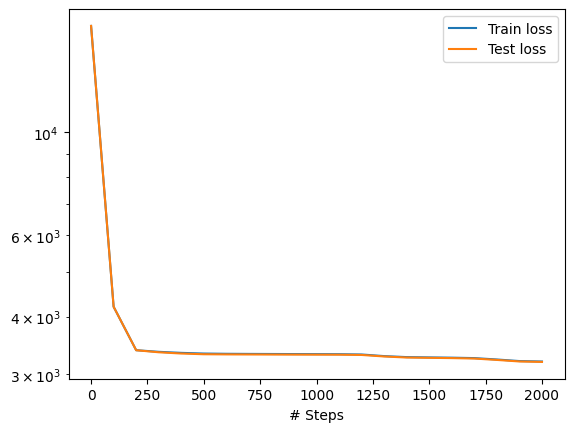

In [20]:
if not(load_pretrained):
    dde.utils.plot_loss_history(losshistory)

## Generate and Plot Predictions

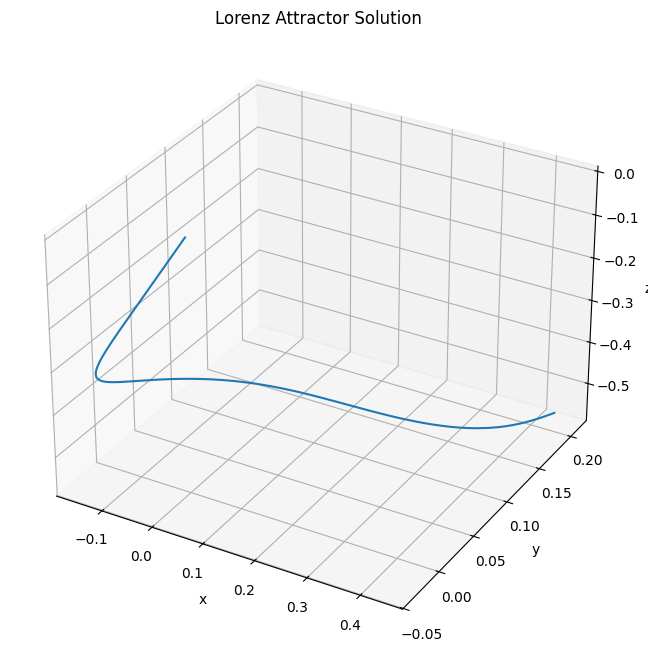

In [6]:
# Generate prediction points
t = np.linspace(0, params['T'], 10001)[:, None]  # More points for smoother plot

xyz_pred = model.predict(t)

plot_solution(t, xyz_pred)

## Save Predictions

In [7]:
# Save the prediction
TEAM_FOLDER = "../"
os.makedirs(TEAM_FOLDER, exist_ok=True)

PREDICTION_FILE = os.path.join(TEAM_FOLDER, "lorenz_prediction.npy")
np.save(PREDICTION_FILE, xyz_pred[5001:10001])

print(f"Saved prediction to: {PREDICTION_FILE}")
print(f"Prediction shape: {xyz_pred[5001:10001].shape}")

Saved prediction to: ../lorenz_prediction.npy
Prediction shape: (5000, 3)
